In [2]:
# Imports
from lib.utils import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm
device = 'cuda'
torch.cuda.empty_cache()

In [8]:
X,y = load_raw_list([20,21,22])

In [11]:
s_idx = np.where(y==1)[0]
w_idx = np.where(y==2)[0]
idx = np.concatenate([s_idx,w_idx])
X = X[idx]
y = y[idx]-1

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train).reshape(-1,1).long()

In [13]:
y_train_one_hot = one_hot(y_train,num_classes=2).reshape(-1,2).float()
y_test_one_hot = one_hot(y_test,num_classes=2).reshape(-1,2).float()
X_train = X_train.reshape(-1,1,5000)
y_train_one_hot = y_train_one_hot
X_test = X_test.reshape(-1,1,5000)
y_test_one_hot = y_test_one_hot
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=1024, shuffle=True)

In [73]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(1, 16, kernel_size=100, stride=10, padding=1)
        self.fc2 = nn.Linear(3920, 2)

    def forward(self,x):
        x = self.c1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(-1, 3920)
        x = self.fc2(x)
        
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [74]:
model(X_train[0].reshape(-1,1,5000).cuda()).shape

torch.Size([1, 2])

In [75]:
train_losses= []
test_losses = []

In [78]:
for epoch in range(200):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_losses.append(training_loss/len(train_dataloader))
    model.eval()
    testing_loss = 0
    for (X,y) in test_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    test_losses.append(testing_loss/len(test_dataloader))
    # if(epoch%10 == 0):
    print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')


Epoch 0 Train: 0.24027936458587645 Test: 0.2560057878494263
Epoch 1 Train: 0.23996669948101043 Test: 0.2525401055812836
Epoch 2 Train: 0.2392687052488327 Test: 0.2507264167070389
Epoch 3 Train: 0.24051902294158936 Test: 0.2560883104801178
Epoch 4 Train: 0.2380981557071209 Test: 0.2516757220029831
Epoch 5 Train: 0.23580800667405127 Test: 0.2549167454242706
Epoch 6 Train: 0.2403236672282219 Test: 0.2505058288574219
Epoch 7 Train: 0.23628311231732368 Test: 0.2547423839569092
Epoch 8 Train: 0.2345749981701374 Test: 0.24968984723091125
Epoch 9 Train: 0.2393472209572792 Test: 0.2540814161300659
Epoch 10 Train: 0.24582844004034995 Test: 0.25242035686969755
Epoch 11 Train: 0.2364118739962578 Test: 0.2495890498161316
Epoch 12 Train: 0.23759366124868392 Test: 0.2691310167312622
Epoch 13 Train: 0.24056139215826988 Test: 0.2577707201242447
Epoch 14 Train: 0.23877953961491585 Test: 0.25015715658664706
Epoch 15 Train: 0.23303630873560904 Test: 0.24916896224021912
Epoch 16 Train: 0.23361555114388466 

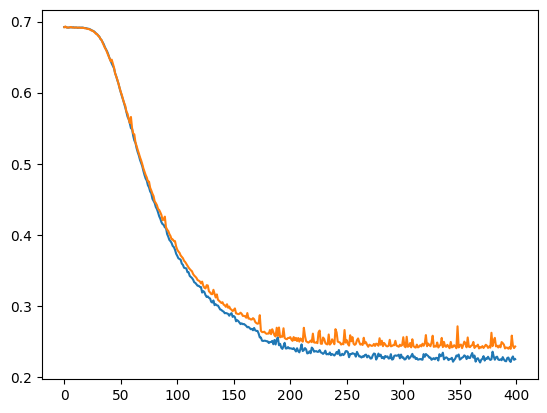

In [79]:
plt.plot(train_losses)
plt.plot(test_losses)

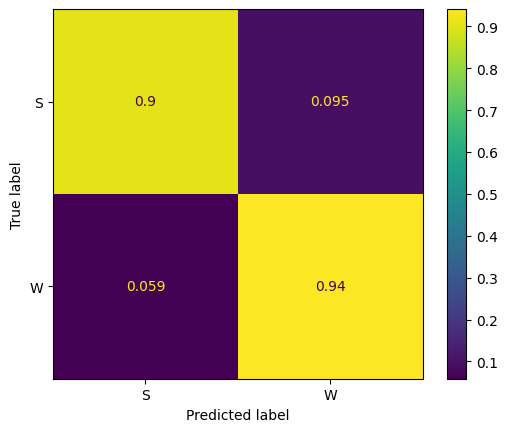

In [80]:
y_pred_logits = model(X_train.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_train_one_hot.argmax(axis=1).cpu().squeeze().cpu(),y_pred.cpu(),normalize='true'),display_labels=['S','W'])
cm.plot()

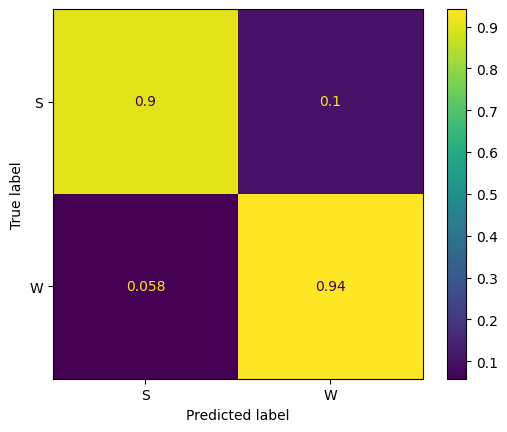

In [81]:
y_pred_logits = model(X_test.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test.squeeze(),y_pred.cpu(),normalize='true'),display_labels=['S','W'])
cm.plot()

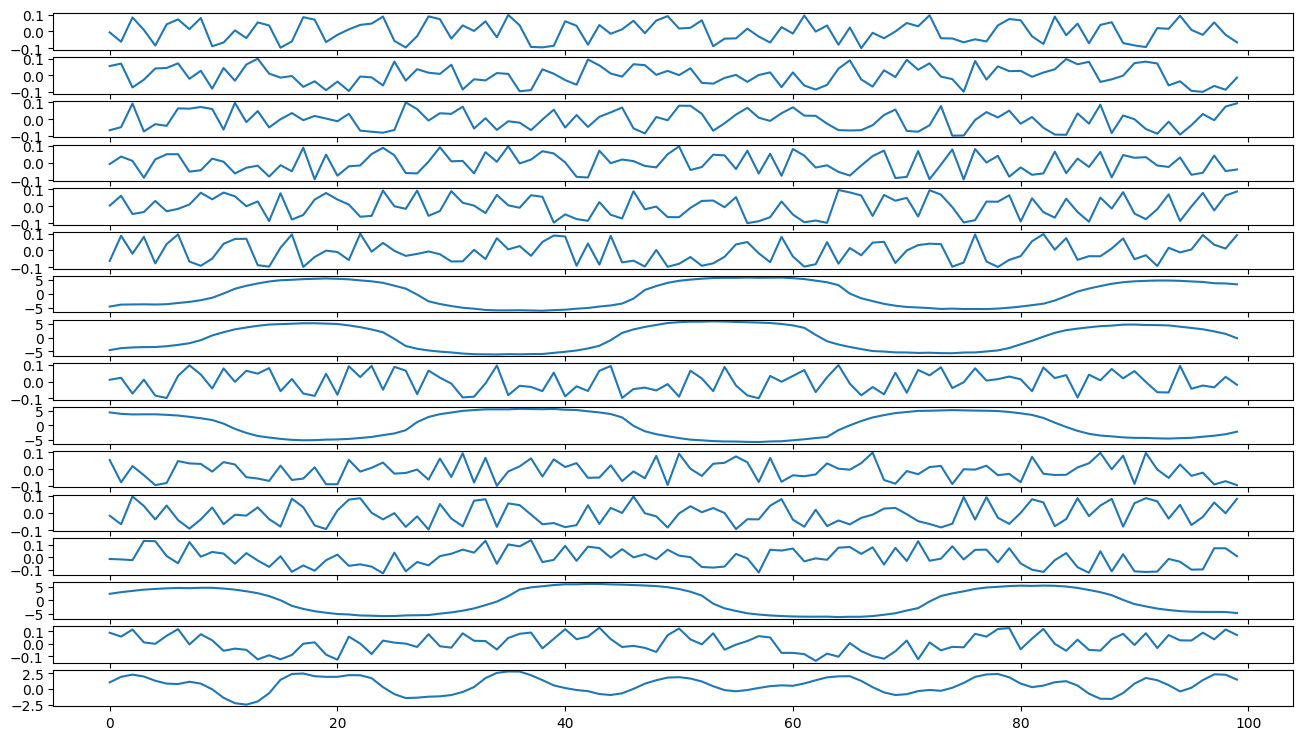

In [82]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(16,9))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('kernels.jpg',dpi=200)